In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import *
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix, classification_report, accuracy_score
def feature_ranking(W):
    """
    This function computes MCFS score and ranking features according to feature weights matrix W
    """
    mcfs_score = np.abs(W).max(1)
    idx = np.argsort(mcfs_score)
    idx = idx[::-1]
    return idx
def construct_W2(X, **kwargs):
    # default metric is 'cosine'
    if "metric" not in kwargs.keys():
        kwargs["metric"] = "cosine"

    # default neighbor mode is 'knn' and default neighbor size is 5
    if "neighbor_mode" not in kwargs.keys():
        kwargs["neighbor_mode"] = "knn"
    if kwargs["neighbor_mode"] == "knn" and "k" not in kwargs.keys():
        kwargs["k"] = 5
    if kwargs["neighbor_mode"] == "supervised" and "k" not in kwargs.keys():
        kwargs["k"] = 5
    if kwargs["neighbor_mode"] == "supervised" and "y" not in kwargs.keys():
        print("Warning: label is required in the supervised neighborMode!!!")
        exit(0)

    # default weight mode is 'binary', default t in heat kernel mode is 1
    if "weight_mode" not in kwargs.keys():
        kwargs["weight_mode"] = "binary"
    if kwargs["weight_mode"] == "heat_kernel":
        if kwargs["metric"] != "euclidean":
            kwargs["metric"] = "euclidean"
        if "t" not in kwargs.keys():
            kwargs["t"] = 1
    elif kwargs["weight_mode"] == "cosine":
        if kwargs["metric"] != "cosine":
            kwargs["metric"] = "cosine"

    # default fisher_score and reliefF mode are 'false'
    if "fisher_score" not in kwargs.keys():
        kwargs["fisher_score"] = False
    if "reliefF" not in kwargs.keys():
        kwargs["reliefF"] = False

    n_samples, n_features = np.shape(X)

    # choose 'knn' neighbor mode
    if kwargs["neighbor_mode"] == "knn":
        k = kwargs["k"]
        if kwargs["weight_mode"] == "binary":
            if kwargs["metric"] == "euclidean":
                # compute pairwise euclidean distances
                D = pairwise_distances(X)
                D **= 2
                # sort the distance matrix D in ascending order
                dump = np.sort(D, axis=1)
                idx = np.argsort(D, axis=1)
                # choose the k-nearest neighbors for each instance
                idx_new = idx[:, 0 : k + 1]
                G = np.zeros((n_samples * (k + 1), 3))
                G[:, 0] = np.tile(np.arange(n_samples), (k + 1, 1)).reshape(-1)
                G[:, 1] = np.ravel(idx_new, order="F")
                G[:, 2] = 1
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

            elif kwargs["metric"] == "cosine":
                # normalize the data first
                X_normalized = np.power(np.sum(X * X, axis=1), 0.5)
                for i in range(n_samples):
                    X[i, :] = X[i, :] / max(1e-12, X_normalized[i])
                # compute pairwise cosine distances
                D_cosine = np.dot(X, np.transpose(X))
                # sort the distance matrix D in descending order
                dump = np.sort(-D_cosine, axis=1)
                idx = np.argsort(-D_cosine, axis=1)
                idx_new = idx[:, 0 : k + 1]
                G = np.zeros((n_samples * (k + 1), 3))
                G[:, 0] = np.tile(np.arange(n_samples), (k + 1, 1)).reshape(-1)
                G[:, 1] = np.ravel(idx_new, order="F")
                G[:, 2] = 1
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

        elif kwargs["weight_mode"] == "heat_kernel":
            t = kwargs["t"]
            # compute pairwise euclidean distances
            D = pairwise_distances(X)
            D **= 2
            # sort the distance matrix D in ascending order
            dump = np.sort(D, axis=1)
            idx = np.argsort(D, axis=1)
            idx_new = idx[:, 0 : k + 1]
            dump_new = dump[:, 0 : k + 1]
            # compute the pairwise heat kernel distances
            dump_heat_kernel = np.exp(-dump_new / (2 * t * t))
            G = np.zeros((n_samples * (k + 1), 3))
            G[:, 0] = np.tile(np.arange(n_samples), (k + 1, 1)).reshape(-1)
            G[:, 1] = np.ravel(idx_new, order="F")
            G[:, 2] = np.ravel(dump_heat_kernel, order="F")
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

        elif kwargs["weight_mode"] == "cosine":
            # normalize the data first
            X_normalized = np.power(np.sum(X * X, axis=1), 0.5)
            for i in range(n_samples):
                X[i, :] = X[i, :] / max(1e-12, X_normalized[i])
            # compute pairwise cosine distances
            D_cosine = np.dot(X, np.transpose(X))
            # sort the distance matrix D in ascending order
            dump = np.sort(-D_cosine, axis=1)
            idx = np.argsort(-D_cosine, axis=1)
            idx_new = idx[:, 0 : k + 1]
            dump_new = -dump[:, 0 : k + 1]
            print("cosine idx idx new")
            print(idx)
            print(idx_new)
            print("dump new")
            print(dump_new)
            G = np.zeros((n_samples * (k + 1), 3))
            G[:, 0] = np.tile(np.arange(n_samples), (k + 1, 1)).reshape(-1)
            G[:, 1] = np.ravel(idx_new, order="F")
            G[:, 2] = np.ravel(dump_new, order="F")
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            print(W)
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            print(W)
            return W

    # choose supervised neighborMode
    elif kwargs["neighbor_mode"] == "supervised":
        k = kwargs["k"]
        # get true labels and the number of classes
        y = kwargs["y"]
        label = np.unique(y)
        n_classes = np.unique(y).size
        # construct the weight matrix W in a fisherScore way, W_ij = 1/n_l if yi = yj = l, otherwise W_ij = 0
        if kwargs["fisher_score"] is True:
            W = lil_matrix((n_samples, n_samples))
            for i in range(n_classes):
                class_idx = y == label[i]
                class_idx_all = class_idx[:, np.newaxis] & class_idx[np.newaxis, :]
                W[class_idx_all] = 1.0 / np.sum(np.sum(class_idx))
            return W

        # construct the weight matrix W in a reliefF way, NH(x) and NM(x,y) denotes a set of k nearest
        # points to x with the same class as x, a different class (the class y), respectively. W_ij = 1 if i = j;
        # W_ij = 1/k if x_j \in NH(x_i); W_ij = -1/(c-1)k if x_j \in NM(x_i, y)
        if kwargs["reliefF"] is True:
            # when xj in NH(xi)
            G = np.zeros((n_samples * (k + 1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                D = pairwise_distances(X[class_idx, :])
                D **= 2
                idx = np.argsort(D, axis=1)
                idx_new = idx[:, 0 : k + 1]
                n_smp_class = (class_idx[idx_new[:]]).size
                if len(class_idx) <= k:
                    k = len(class_idx) - 1
                G[id_now : n_smp_class + id_now, 0] = np.tile(class_idx, (k + 1, 1)).reshape(-1)
                G[id_now : n_smp_class + id_now, 1] = np.ravel(class_idx[idx_new[:]], order="F")
                G[id_now : n_smp_class + id_now, 2] = 1.0 / k
                id_now += n_smp_class
            W1 = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            # when i = j, W_ij = 1
            for i in range(n_samples):
                W1[i, i] = 1
            # when x_j in NM(x_i, y)
            G = np.zeros((n_samples * k * (n_classes - 1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx1 = np.column_stack(np.where(y == label[i]))[:, 0]
                X1 = X[class_idx1, :]
                for j in range(n_classes):
                    if label[j] != label[i]:
                        class_idx2 = np.column_stack(np.where(y == label[j]))[:, 0]
                        X2 = X[class_idx2, :]
                        D = pairwise_distances(X1, X2)
                        idx = np.argsort(D, axis=1)
                        idx_new = idx[:, 0:k]
                        n_smp_class = len(class_idx1) * k
                        G[id_now : n_smp_class + id_now, 0] = np.tile(class_idx1, (k, 1)).reshape(-1)
                        G[id_now : n_smp_class + id_now, 1] = np.ravel(class_idx2[idx_new[:]], order="F")
                        G[id_now : n_smp_class + id_now, 2] = -1.0 / ((n_classes - 1) * k)
                        id_now += n_smp_class
            W2 = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W2) > W2
            W2 = W2 - W2.multiply(bigger) + np.transpose(W2).multiply(bigger)
            W = W1 + W2
            return W

        if kwargs["weight_mode"] == "binary":
            if kwargs["metric"] == "euclidean":
                G = np.zeros((n_samples * (k + 1), 3))
                id_now = 0
                for i in range(n_classes):
                    class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                    # compute pairwise euclidean distances for instances in class i
                    D = pairwise_distances(X[class_idx, :])
                    D **= 2
                    # sort the distance matrix D in ascending order for instances in class i
                    idx = np.argsort(D, axis=1)
                    idx_new = idx[:, 0 : k + 1]
                    n_smp_class = len(class_idx) * (k + 1)
                    G[id_now : n_smp_class + id_now, 0] = np.tile(class_idx, (k + 1, 1)).reshape(-1)
                    G[id_now : n_smp_class + id_now, 1] = np.ravel(class_idx[idx_new[:]], order="F")
                    G[id_now : n_smp_class + id_now, 2] = 1
                    id_now += n_smp_class
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

            if kwargs["metric"] == "cosine":
                # normalize the data first
                X_normalized = np.power(np.sum(X * X, axis=1), 0.5)
                for i in range(n_samples):
                    X[i, :] = X[i, :] / max(1e-12, X_normalized[i])
                G = np.zeros((n_samples * (k + 1), 3))
                id_now = 0
                for i in range(n_classes):
                    class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                    # compute pairwise cosine distances for instances in class i
                    D_cosine = np.dot(X[class_idx, :], np.transpose(X[class_idx, :]))
                    # sort the distance matrix D in descending order for instances in class i
                    idx = np.argsort(-D_cosine, axis=1)
                    idx_new = idx[:, 0 : k + 1]
                    n_smp_class = len(class_idx) * (k + 1)
                    G[id_now : n_smp_class + id_now, 0] = np.tile(class_idx, (k + 1, 1)).reshape(-1)
                    G[id_now : n_smp_class + id_now, 1] = np.ravel(class_idx[idx_new[:]], order="F")
                    G[id_now : n_smp_class + id_now, 2] = 1
                    id_now += n_smp_class
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

        elif kwargs["weight_mode"] == "heat_kernel":
            G = np.zeros((n_samples * (k + 1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                # compute pairwise cosine distances for instances in class i
                D = pairwise_distances(X[class_idx, :])
                D **= 2
                # sort the distance matrix D in ascending order for instances in class i
                dump = np.sort(D, axis=1)
                idx = np.argsort(D, axis=1)
                idx_new = idx[:, 0 : k + 1]
                dump_new = dump[:, 0 : k + 1]
                t = kwargs["t"]
                # compute pairwise heat kernel distances for instances in class i
                dump_heat_kernel = np.exp(-dump_new / (2 * t * t))
                n_smp_class = len(class_idx) * (k + 1)
                G[id_now : n_smp_class + id_now, 0] = np.tile(class_idx, (k + 1, 1)).reshape(-1)
                G[id_now : n_smp_class + id_now, 1] = np.ravel(class_idx[idx_new[:]], order="F")
                G[id_now : n_smp_class + id_now, 2] = np.ravel(dump_heat_kernel, order="F")
                id_now += n_smp_class
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

        elif kwargs["weight_mode"] == "cosine":
            # normalize the data first
            X_normalized = np.power(np.sum(X * X, axis=1), 0.5)
            for i in range(n_samples):
                X[i, :] = X[i, :] / max(1e-12, X_normalized[i])
            G = np.zeros((n_samples * (k + 1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                # compute pairwise cosine distances for instances in class i
                D_cosine = np.dot(X[class_idx, :], np.transpose(X[class_idx, :]))
                # sort the distance matrix D in descending order for instances in class i
                dump = np.sort(-D_cosine, axis=1)
                idx = np.argsort(-D_cosine, axis=1)
                idx_new = idx[:, 0 : k + 1]
                dump_new = -dump[:, 0 : k + 1]
                n_smp_class = len(class_idx) * (k + 1)
                G[id_now : n_smp_class + id_now, 0] = np.tile(class_idx, (k + 1, 1)).reshape(-1)
                G[id_now : n_smp_class + id_now, 1] = np.ravel(class_idx[idx_new[:]], order="F")
                G[id_now : n_smp_class + id_now, 2] = np.ravel(dump_new, order="F")
                id_now += n_smp_class
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

In [2]:
import numpy as np
import scipy
from scipy.linalg import eigh
from sklearn import linear_model

# from skfeature.utility.construct_W import construct_W
from skfeature.utility.util import reverse_argsort


def mcfs2(X, y=None, n_selected_features=None, mode="rank", **kwargs):
    """
    This function implements unsupervised feature selection for multi-cluster data.

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    n_selected_features: {int}
        number of features to select
    kwargs: {dictionary}
        W: {sparse matrix}, shape (n_samples, n_samples)
            affinity matrix
        n_clusters: {int}
            number of clusters (default is 5)

    Output
    ------
    W: {numpy array}, shape(n_features, n_clusters)
        feature weight matrix

    Reference
    ---------
    Cai, Deng et al. "Unsupervised Feature Selection for Multi-Cluster Data." KDD 2010.
    """

    def feature_ranking(W):
        """
        This function computes MCFS score and ranking features according to feature weights matrix W
        """
        mcfs_score = np.abs(W).max(1)
        idx = np.argsort(mcfs_score)
        idx = idx[::-1]
        return idx
    

    if n_selected_features is None:
        n_selected_features = int(X.shape[1])

    # use the default affinity matrix
    if "W" not in kwargs:
        W = construct_W2(X) #15:32
    else:
        W = kwargs["W"]
    # default number of clusters is 5
    if "n_clusters" not in kwargs:
        n_clusters = 5
    else:
        n_clusters = kwargs["n_clusters"]

    # solve the generalized eigen-decomposition problem and get the top K
    # eigen-vectors with respect to the smallest eigenvalues
    W = W.toarray()
    # W = (W + W.T) / 2
    D = np.diag(W.sum(axis=1))
    L = D - W
    eigenvalues, eigenvectors = eigh(L, D)
    

    # solve K L1-regularized regression problem using LARs algorithm with cardinality constraint being d
    n_sample, n_feature = X.shape
    W = np.zeros((n_feature, n_clusters))
    for i in range(n_clusters):
        clf = linear_model.Lars(n_nonzero_coefs=n_selected_features)
        clf.fit(X, eigenvectors[:, i])
        W[:, i] = clf.coef_

    if mode == "raw":
        return W
    elif mode == "index":
        return feature_ranking(W)
    elif mode == "rank":
        W_idx = feature_ranking(W)
        return reverse_argsort(W_idx, X.shape[1])

In [3]:

    

# Define the column names based on the dataset description
column_names = [
    'ID', 'Diagnosis',
    'Mean Radius', 'Mean Texture', 'Mean Perimeter', 'Mean Area', 'Mean Smoothness',
    'Mean Compactness', 'Mean Concavity', 'Mean Concave Points', 'Mean Symmetry', 'Mean Fractal Dimension',
    'SE Radius', 'SE Texture', 'SE Perimeter', 'SE Area', 'SE Smoothness',
    'SE Compactness', 'SE Concavity', 'SE Concave Points', 'SE Symmetry', 'SE Fractal Dimension',
    'Worst Radius', 'Worst Texture', 'Worst Perimeter', 'Worst Area', 'Worst Smoothness',
    'Worst Compactness', 'Worst Concavity', 'Worst Concave Points', 'Worst Symmetry', 'Worst Fractal Dimension'
]

print(len(column_names))
# Load the data
data = pd.read_csv('wdbc.data', names=column_names)

# Display the first few rows (optional)
print("First few rows of the dataset:")
print(data.head())

# Map Diagnosis to numerical values: M=1 (malignant), B=0 (benign)
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

# Check for any missing values
if data.isnull().sum().any():
    print("Data contains missing values. Please handle them before proceeding.")
    # Optionally, handle missing values here
else:
    print("No missing values detected.")

# Separate features and labels
X = data.drop(['ID', 'Diagnosis'], axis=1).values
y = data['Diagnosis'].values

# Preprocess the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set parameters
n_clusters = 2  # Number of clusters (malignant and benign)
n_selected_features = 20  # Number of features to select
k = 5  # Number of neighbors for graph construction

# Construct the affinity matrix W
kwargs_W = {
    "metric": "cosine",
    "neighbor_mode": "knn",
    "weight_mode": "cosine",
    "k": k,
    "t": 1.2
}
W = construct_W2(X_scaled, **kwargs_W)

# Perform MCFS feature selection
# Note: Ensure that MCFS in your library version supports supervised feature selection
#Weight = MCFS.mcfs(X_scaled, y=y, n_selected_features=n_selected_features, W=W, n_clusters=n_clusters)
weights = mcfs2(X_scaled, W=W, n_selected_features=n_selected_features, n_clusters=n_clusters, mode="raw")
ranking = feature_ranking(weights)


# Manually rank the features based on the Weight matrix
feature_ranking_indices = ranking[:n_selected_features]

# Select the top features
selected_features_indices = feature_ranking_indices[:n_selected_features]
X_selected = X_scaled[:, selected_features_indices]

# Perform KMeans clustering using the selected features
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_selected)

# Map cluster labels to match the original labels (optional step)
acc_original = accuracy_score(y, cluster_labels)
acc_inverted = accuracy_score(y, 1 - cluster_labels)

if acc_inverted > acc_original:
    cluster_labels = 1 - cluster_labels

# Evaluate clustering performance
ari = adjusted_rand_score(y, cluster_labels)
print(f"\nAdjusted Rand Index (ARI): {ari:.4f}")

# Print confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y, cluster_labels))

print("\nClassification Report:")
print(classification_report(y, cluster_labels, target_names=['Benign', 'Malignant']))

# Print the top selected features with their weights
print("\nTop selected features:")
for rank, idx in enumerate(selected_features_indices, start=1):
    feature_name = column_names[idx + 2]  # Adjust index for 'ID' and 'Diagnosis' columns
    feature_weight = np.abs(weights).max(1)[idx]
    print(f"{rank}. {feature_name} (Weight: {feature_weight:.4f})")


32
First few rows of the dataset:
         ID Diagnosis  Mean Radius  Mean Texture  Mean Perimeter  Mean Area  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   Mean Smoothness  Mean Compactness  Mean Concavity  Mean Concave Points  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  Worst Radius  Worst 

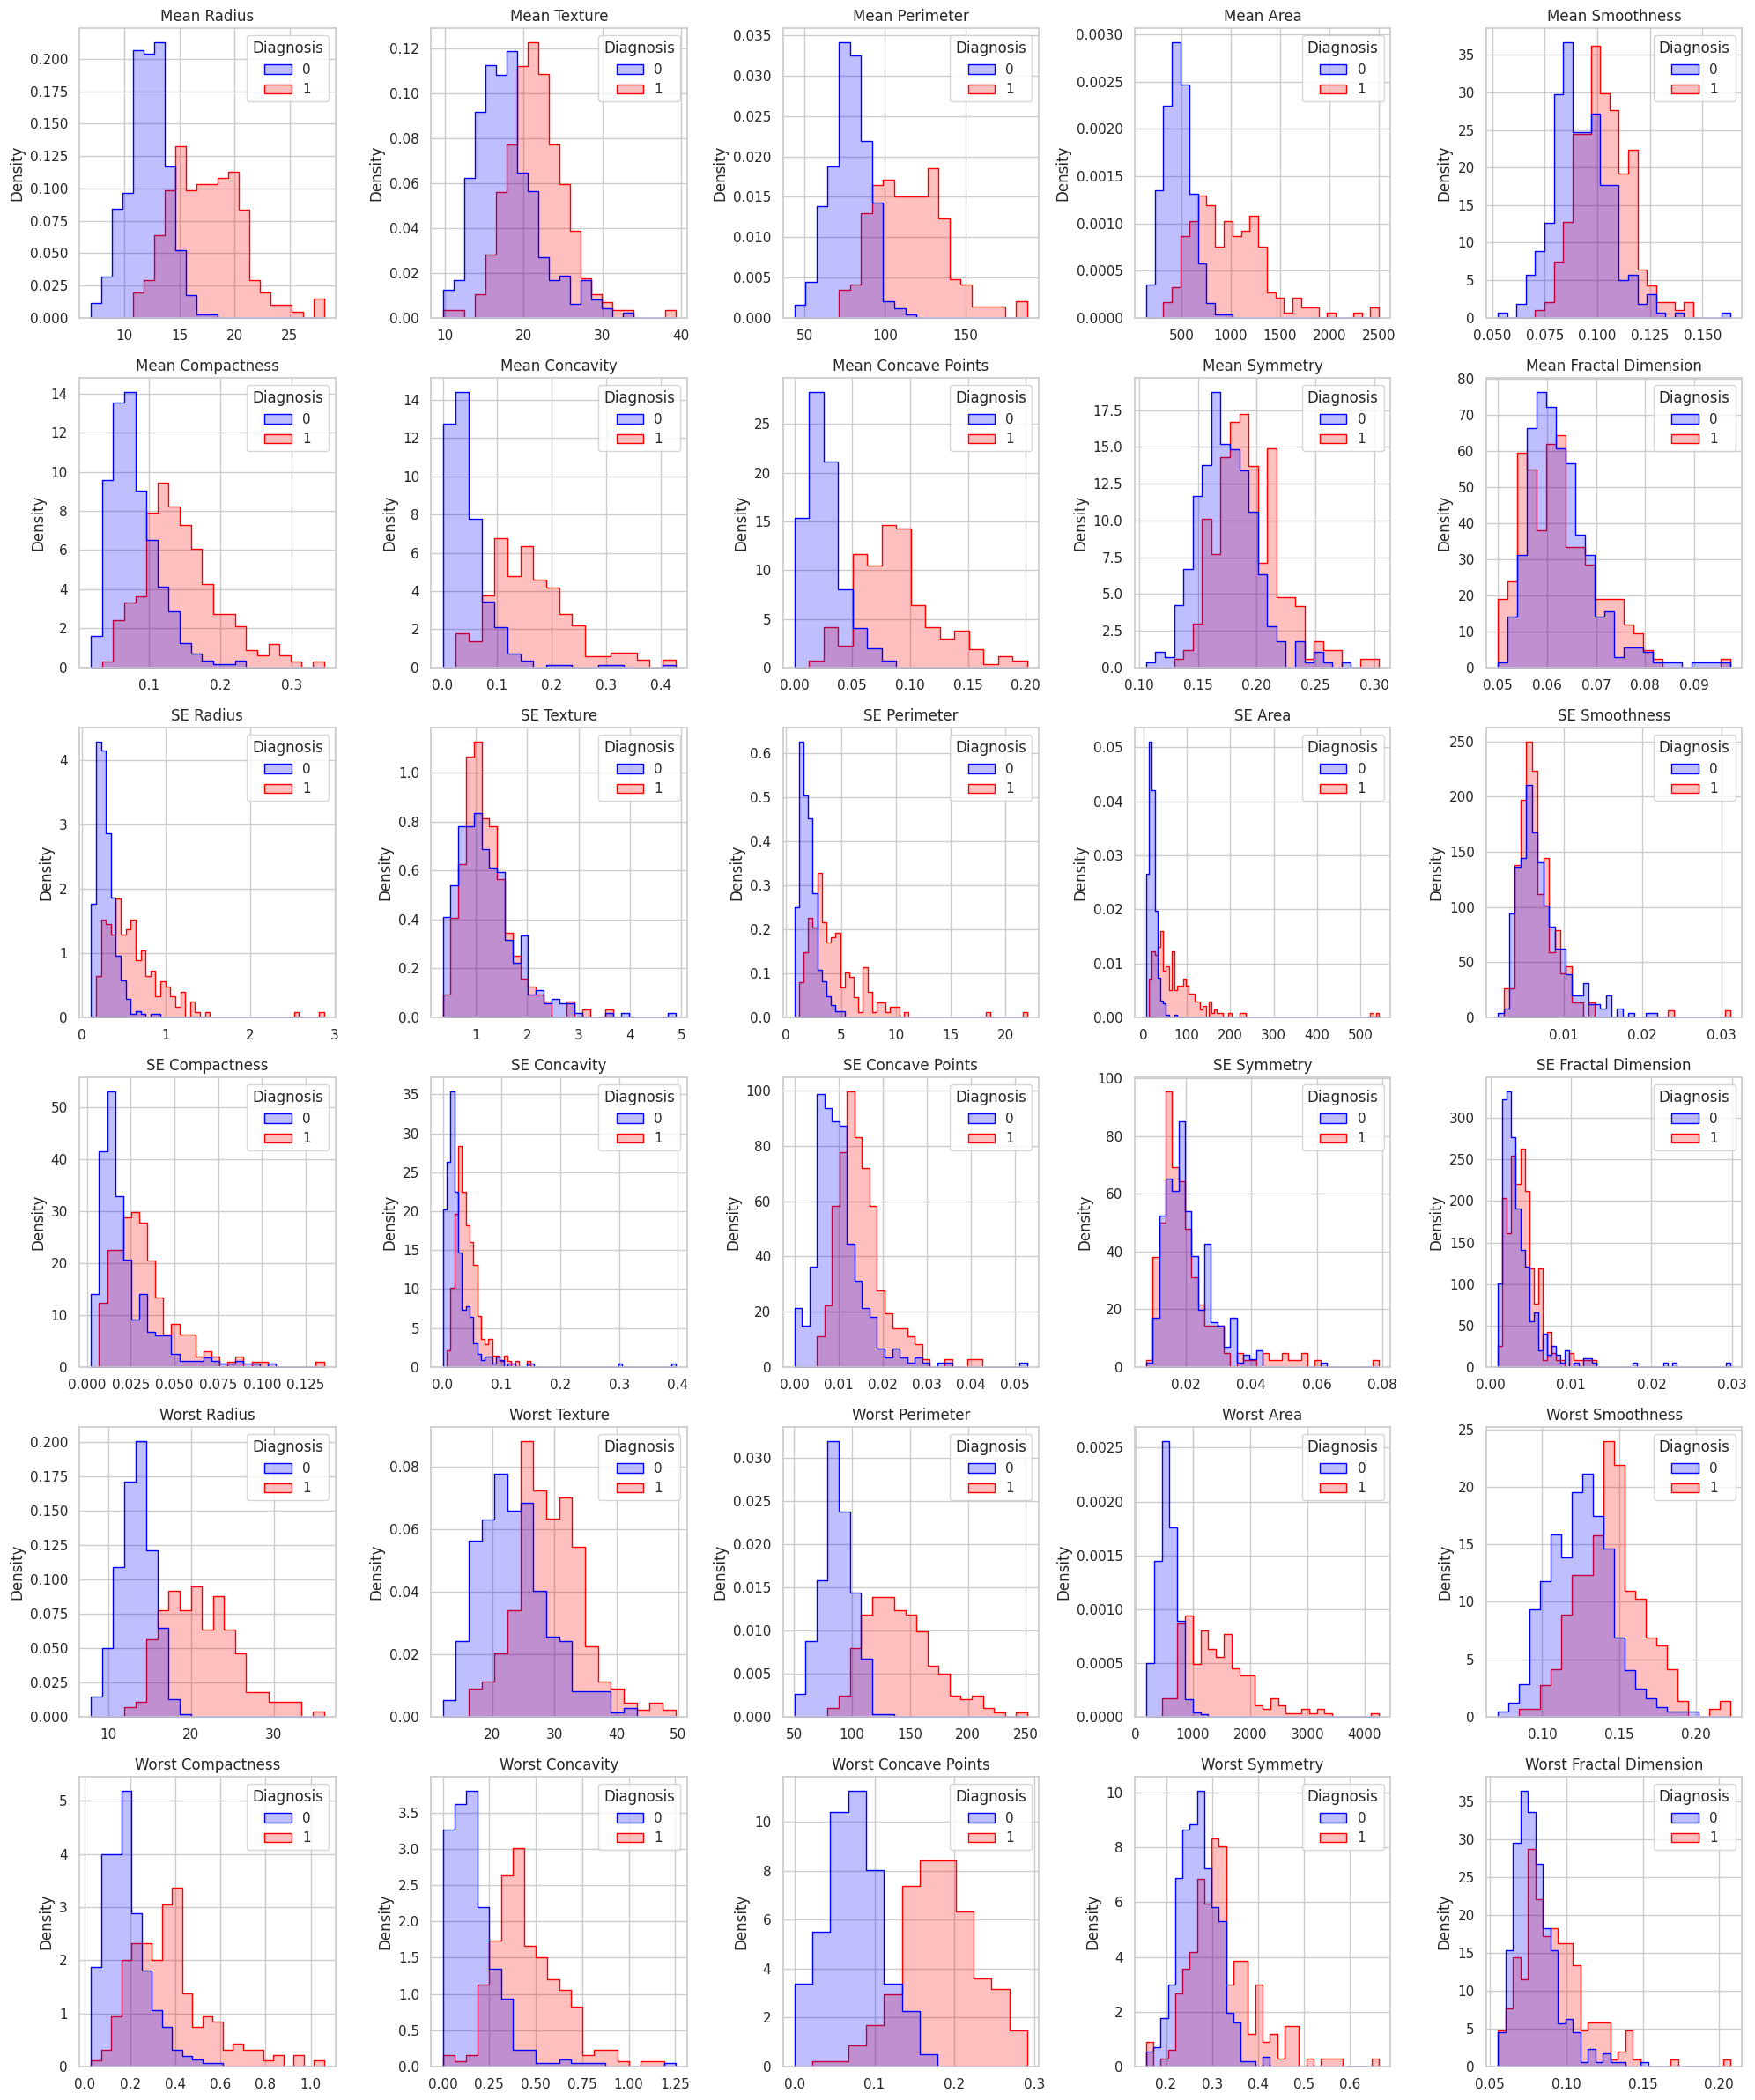

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the column names based on the dataset description 
column_names = [
    'ID', 'Diagnosis',
    'Mean Radius', 'Mean Texture', 'Mean Perimeter', 'Mean Area', 'Mean Smoothness',
    'Mean Compactness', 'Mean Concavity', 'Mean Concave Points', 'Mean Symmetry', 'Mean Fractal Dimension',  
    'SE Radius', 'SE Texture', 'SE Perimeter', 'SE Area', 'SE Smoothness',
    'SE Compactness', 'SE Concavity', 'SE Concave Points', 'SE Symmetry', 'SE Fractal Dimension',
    'Worst Radius', 'Worst Texture', 'Worst Perimeter', 'Worst Area', 'Worst Smoothness',
    'Worst Compactness', 'Worst Concavity', 'Worst Concave Points', 'Worst Symmetry', 'Worst Fractal Dimension'
]

# Load the data
data = pd.read_csv('wdbc.data', names=column_names)

# Map Diagnosis to numerical values: M=1 (malignant), B=0 (benign)
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

# Drop the ID column as it's not useful for visualization
data.drop('ID', axis=1, inplace=True)

# Set the style for seaborn
sns.set(style="whitegrid")

# List of features to plot
features = data.columns.drop('Diagnosis')

# Number of features
num_features = len(features)

# Determine the number of rows and columns for the subplot grid
num_cols = 5
num_rows = int(np.ceil(num_features / num_cols))

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for idx, feature in enumerate(features):
    ax = axes[idx]
    sns.histplot(data=data, x=feature, hue='Diagnosis', element='step', stat='density', common_norm=False, palette={0: 'blue', 1: 'red'}, ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('')
    ax.set_ylabel('Density')

# Remove any empty subplots
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
